# INF581 - Lab 02

## Objectives

In Lab 01, we looked at a full pipeline for an agent, from perception to inference (reasoning from knowledge $P$) and decision making. However, there were two elements worth studying:

1. Scalability -- how to perform approximate inference when it is not feasible to track all feasible solutions?
2. Learning -- if $P$ is not available beforehand; how to assimilate knowledge from data (machine learning, and deep learning)?

We approach these questions through the lens of multi-label learning, but the answers could be equally applied as an extension to Lab 01.


## Task 0: Enter your ID

Don't forget to enter your email address in the box below. 

In [1]:
## EXTRACT ID

# TODO replace the following Email with your own
    
info = {
        'Email' : 'yannis.kedadry@polytechnique.edu',
        'Alias' : 'yKedadry', # (change this in case you want to identify yourself on the leaderboard)
}


## Part 1: Scalability (Monte Carlo Search)

In classifier chains (see lecture slides for background and illustration), we have a Bayesian network which specifies a joint distribution over outputs $p(y_1,\ldots,y_m)$. Due to the high connectivity in the DAG, there are $2^m$ possible combinations of outputs. 

One option is to do _greedy_ inference, this is certainly scalable; but greedy is not the same as _optimal_, and we would like an approximation that is closer to optimal. You will implement Monte Carlo search for inference.

But first, 

### Preliminaries

In [2]:
## EXTRACT Imports

import numpy as np

random_state = 0

In [4]:
from graphviz import Digraph

def draw_tree(nodes,edges,y_pred=None,p_pred=None,title=''):
    '''
        draw a tree, with these nodes and edges
    '''
    G = Digraph(comment=title)
    G.node_attr.update(shape='box', style='rounded')
    for n in nodes.keys():
        if n == str(y_pred) and nodes[n] == p_pred:
            G.node(n,label='''<{<B>%s</B> | %3.2f}>''' % (n,nodes[n]),shape='record',fontcolor='blue')
        else:
            G.node(n,label='''<{<B>%s</B> | %3.2f}>''' % (n,nodes[n]),shape='record')
    for e_key in edges.keys():
        l,r = e_key.split('--')
        G.edge(l,r,"%3.2f" % edges[e_key])
    return G

### Training Classifier Chains

The following code simply trains classifier chains on the music-emotions dataset (Trohidis et al., 2011), where attributes describing a piece of music are associated to a subset of six emotions: amazed-surprised, happy-pleased, relaxing-clam, quiet-still, sad-lonely, and angry-aggressive. 

We use a random node ordering in the chain. But, of course, it is a legitimate question (outside the scope of this lab task): which is the best order?

In [5]:
from sklearn.model_selection import train_test_split
m = 6
XY = np.genfromtxt('music.csv', skip_header=1, delimiter=",")
n,d_plus_m = XY.shape
d = d_plus_m - m
X = XY[:,m:d_plus_m]
Y = XY[:,0:m]
n_test = 1
n_train = n-n_test
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=n_test, random_state=random_state)

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
cc = ClassifierChain(LogisticRegression(solver='liblinear'), order="random", random_state=random_state)
cc.fit(X_train,Y_train)

# Instantiate all models of the chain
chain = [LogisticRegression(solver='liblinear') for j in range(m)]

# Prepare the feature and target space(s)
XY = np.zeros((n, d + m-1))
XY[:,0:d] = X
XY[:,d:] = Y[:,0:m-1]

# Train each individual classifier
for j in range(m):
    chain[j].fit(XY[:,0:d+j], Y[:,j])



### Greedy inference

In the following there is an example of greedy inference. Essentially, this is $\mathbf{\hat y} = h(\mathbf{x})$ where $\mathbf{x}$ is the test instance and Bayesian network $p$ is provided via the probabilistic classifiers in `chain`. The function returns both $\mathbf{y}$ and its associated probability. 

In [6]:
def greedy(x, h, nodes = {}, edges = {}):
    """ Inference via greedy search.
    
        Determines argmax_y p(y|x). 
        
        (And also fills `nodes` and `edges` for visualization later)

        Parameters
        ----------

        x : array_like (float, ndim=1) of length n_features 
            test instance

        h : list (of classifiers)
            the probabilistic classifiers that represent the chain

        nodes : dict(str,float)
            where dict[str(y)] = P(y | x)

        edges : dict(str,float)
            where dict[str(y)+'--'+str(y)] = P(y[j] | y[j-1], x) 


        Returns
        -------

        y : array_like(int,ndim=1) array of length m
            label vector

        p : float
            P(y | x) the posterior probability 
    """

    m = len(h)
    y = np.zeros(m, dtype=int)              # an array to store labels (best path)
    p = 1.                       # path score 'so far'
    xy = x.reshape(1,-1)         # array of shape (n_labels,n_features) is required by sklearn

    for j in range(m):
        if j>0:
            # stack the previous y as an additional feature
            xy = np.column_stack([xy, y[j-1]])
        # P_j := P(y[j]|x,y[1],...,y[j-1])
        P_j = h[j].predict_proba(xy)[0] # (N.B. [0], because it is the first and only row)
        k = np.argmax(P_j)
        y[j] = k
        p = p * P_j[k]

        edges[str(y[0:j])+'--'+str(y[0:j+1])] = P_j[k]
        nodes[str(y[0:j+1])] = p

    return y,p


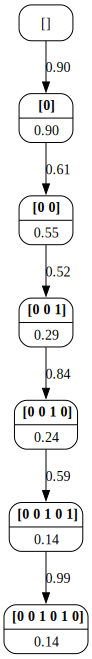

In [7]:
# Draw the resulting 'tree'
nodes = {}
edges = {}
y_greedy, p_greedy = greedy(x_test, chain, nodes, edges)
G = draw_tree(nodes,edges)
G

### Task 1: Implementing Monte Carlo Search

The function `sample` below should return a sample $\mathbf{y} \sim p(\mathbf{y} | \mathbf{x})$ where $\mathbf{x}$ is the test instance and Bayesian network $p$ is provided via the probabilistic classifiers (logistic regression) in `chain`. Note that the function returns both $\mathbf{y}$ and its associated probability. 

#### Task 1a: Implement the sample function

In [ ]:
## EXTRACT Task 1a

def sample(x, h, nodes={}, edges={}):
    '''
        Sample y ~ P(y|x)

        Returns
        -------
        y: a sampled label vector
        p: the associated probabilities, i.e., p(y_j=1)=p_j
    '''
    d = len(x)
    m = len(h)

    y = np.zeros(m,dtype=int)
    p = 1.
    
    # TODO 
    
    return y, p


#### Task 1b Implement the inference function

Complete the following function. 

In [ ]:
## EXTRACT Task 1b

def mc_search(x, h, nodes={}, edges={}, n_samples=10):
    ''' mc search'''
    p_max = 0
    y_max = None

    # TODO
    
    return y_max, p_max



Let's check how this compares to the 'greedy' prediction, for the same instance. 

In [ ]:
# Evaluate 
nodes = {}
edges = {}
y_pred, p_pred = mc_search(x_test[0], chain, nodes, edges)
# And compare vs greedy inference
print("MC-Search: p(%s | x) = %3.2f" % (str(y_pred), p_pred))
print("   Greedy: p(%s | x) = %3.2f" % (str(y_greedy), p_greedy))

In [ ]:
# View the resulting search tree
G = draw_tree(nodes, edges, y_pred, p_pred)
G

### Conclusions?

Think about if/how Monte Carlo search could have been implemented for the tasks in Lab 01.  

## Task 2: Machine Learning (PyTorch)

In this task we will construct a deep architecture with two connected heads. Such architectures with multiple heads are commonplace in reinforcement learning (and other areas where non-simplistic architectures are required). It can even help in this case of multi-label learning (as opposed to a basic pipeline of layers from input to output).

We will use the music-emotions data, as considered in Task 1, to keep the computational complexity reasonable. Hence, again, our interest is in: 
$$
    p(\mathbf{y} | \mathbf{x})
$$
where $\mathbf{y} = [y_1,\ldots,y_m]$. 

The main objective of this task is firstly, appreciating the role that machine learning plays in providing a representation of knowledge, and secondly, becoming familiar with designing non-trivial architectures.

This task assumes familiarity with PyTorch. 

In [ ]:
# Re-split the data (to have more test examples)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=100, random_state=random_state)

In [ ]:
## EXTRACT Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

### The Model  / Network

You should design a network like this:
* the first layer connects input `x` to hidden nodes `z` (ReLU activation)
* another layer connects `z` to the first half of the outputs `l` (sigmoid activation), i.e., representing $y_1,y_2,y_3$. 
* we connect `l` to another layer `u`
* finaly, connect *both* `z` and `u` to `r` which represents the second half of outputs (sigmoid activation), i.e., representing $y_4,y_5,y_6$.

The sizes of `z` and `u` can be given in the parameter dictionary `sizes`.

What justification for such an architecture? This is somewhere inbetween  classifier chains and more typical multi-output neural networks. We get a bit of 'capacity for free', but we also add the typical deep layer(s) of a neural network to properly embed the input and label concepts. If this hierarchical representation reflects the data, then we can (using, e.g., MC-search) estimate the joint probability $p(\mathbf{y} | \mathbf{x})$. 



In [ ]:
## EXTRACT Task 2 

class MyNetwork1(nn.Module):

    def __init__(self, d, m, sizes = {'z' : 50, 'u' : 10}):
        '''
            Setup a network Module.

            (as described above)

            Parameters
            ----------

            d : int
                number of input nodes/features
            m : int
                number of output nodes/labels/targets
            sizes : dict.
              specify the sizes of the 'hidden' layers

        '''
        super(MyNetwork1, self).__init__()

        # TODO 

    def forward(self, x):
        '''
            Defines the forward pass of the network, from input to output.

            (again, you may use the description above)

            Parameters
            ----------

            x : Tensor
                representing the input instance(s)

            Returns
            -------

            y : Tensor
                representing the output labels
        '''
        # TODO 
        return y



Initialize the network

In [ ]:
h_deep = MyNetwork1(d,m)

#### Training

How to train this thing? First question: under which loss? This is an important question. For now, let's use 'binary cross entropy'.

Just run the following code to train your network (once you have implemented it).


In [ ]:
## EXTRACT fit function

def fit(h, X, Y, n_epochs=100):
    '''
        Train the network.

        Parameters
        ----------
        h : ptorch module
            the network
        X : numpy array of shape (n, d)
            instances
        Y : numpy array of shape (n, m)
            labels
        n_epochs : int
            number of epochs

    '''

    # Check the shape
    n = len(X)

    # Optimizer
    optimizer = optim.Adam(h.parameters(),0.001)

    # Loss
    my_loss = torch.nn.BCELoss()

    # Fit the Model
    for t in range(n_epochs):
        losses = []
        for i in range(n):
            h.train()

            x_variable = torch.FloatTensor(X[i]).view(1, -1)
            y_variable = torch.FloatTensor(Y[i]).view(1, -1)

            output = h(x_variable)

            loss = my_loss(output, y_variable)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data.mean())
        print('[%d/%d] Loss: %.3f' % (t+1, n_epochs, np.mean(losses)))
    return h

In [ ]:
# Train it
fit(h_deep,X_train,Y_train)

#### Prediction and Evaluation

We need the predictions of label relevances for instances in the test set. We used sigmoid activation functions for each label, which represents the probability, according to our model, that each label should be assigned a 1 (indicating relevance); i.e.,  $\sigma_j \equiv p(y_j | \bf{x})$. Let's walk away with these numbers, since it's easy to obtain the binary label predictions $\hat y_j \in \{0,1\}$ where $\hat y_j = \text{argmax}_{y_j \in \{0,1\}} p(y_j \mid \bf{x})$, via a threshold of $0.5$.

In [ ]:
## EXTRACT infererence

def predict_proba(h, X):
    '''
        Produce confidence for predicting 1 for each label for each instance in X.

        Parameters
        ----------

        h : model
            the PyTorch model/network
        X : numpy array of shape (n, d)
            test instances

        Returns
        -------

        P_Y : array of shape (n, m) where m the number of labels/outputs,
              such that P_Y[i,j] is the relevance of the j-th label to the i-th instance.
    '''

    n_test = len(X)
    P_Y = []

    # Test the model on test data
    with torch.no_grad():
       for i in range(n_test):

            x_t_variable = torch.FloatTensor(X[i]).view(1, -1)

            output = h(x_t_variable)
            p_y = torch.Tensor.numpy(output.detach())

            P_Y.append(p_y[0])

    return np.array(P_Y)

In [ ]:
# Evaluate for exact-match (0/1 loss)
P_pred = predict_proba(h_deep, X_test)
Y_pred = (P_pred >= 0.5) * 1
print(np.mean(np.sum(Y_pred == Y_test,axis=1) == m))

### Conclusions and Reflection

What does the output in the previous cell signify?

How come that structure in particular? Wouldn't it work better to learn the structure from the data? Yes, this is intensive, but can be done; it can even be done with the same search methods we are using for inference (especially, e.g., Monte Carlo search). But others (that we will study in coming weeks) will be more suited. 
